In [ ]:
import os
import glob
import numpy as np
from datetime import datetime
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import sigmoid_focal_loss
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

import matplotlib.pyplot as plt
from matplotlib import gridspec

import pandas as pd
import xarray as xr
from skimage.util import view_as_windows
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm
from scipy.ndimage import label

## Architecture

In [ ]:
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        else:
            return focal_loss.sum()

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim,
                              kernel_size=kernel_size, padding=padding)

        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

class SqueezeExcite(nn.Module):
    def __init__(self, channel, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class ResConvLSTM(nn.Module):
    def __init__(self, in_channels, hidden_dim=32, patch_size=7, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.patch_size = patch_size
        self.dropout = dropout

        self.input_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.se = SqueezeExcite(hidden_dim)

        self.lstm_cell = ConvLSTMCell(hidden_dim, hidden_dim)

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1x1 = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        B, C, T, H, W = x.size()
        h, c = torch.zeros(B, self.hidden_dim, H, W, device=x.device), \
               torch.zeros(B, self.hidden_dim, H, W, device=x.device)

        for t in range(T):
            x_t = x[:, :, t, :, :]
            x_t = self.input_conv(x_t)
            x_t = self.bn(x_t)
            x_t = F.relu(x_t)
            x_t = self.se(x_t)

            h, c = self.lstm_cell(x_t, h, c)

        out = self.global_pool(h)
        out = self.conv1x1(out)
        out = out.view(B)
        return out

In [ ]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim,
                              kernel_size=kernel_size, padding=padding)

        self.hidden_dim = hidden_dim

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.chunk(conv_output, 4, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c

class SqueezeExcite(nn.Module):
    def __init__(self, channel, reduction=4):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        # takes max+avg pooled channels → 1-channel attention map
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # channel‐wise avg/max → each is (B,1,H,W)
        avg = torch.mean(x, dim=1, keepdim=True) # general trend across all pixels
        mx  = torch.max(x,  dim=1, keepdim=True)[0] # strong pixels
        attn = torch.cat([avg, mx], dim=1)
        attn = self.sigmoid(self.conv(attn))
        return x * attn

class ResConvLSTMwithAttention(nn.Module):
    def __init__(self, in_channels, hidden_dim=32, patch_size=7, dropout=0.3):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.patch_size = patch_size
        self.dropout = dropout

        self.input_conv = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(hidden_dim)
        self.se = SqueezeExcite(hidden_dim)

        self.lstm_cell = ConvLSTMCell(hidden_dim, hidden_dim)

        self.spatial_attn = SpatialAttention()

        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.conv1x1 = nn.Conv2d(hidden_dim, 1, kernel_size=1)

    def forward(self, x):
        B, C, T, H, W = x.size()
        h1, c1 = torch.zeros(B, self.hidden_dim, H, W, device=x.device), \
               torch.zeros(B, self.hidden_dim, H, W, device=x.device)
        h2, c2 = torch.zeros(B, self.hidden_dim, H, W, device=x.device), \
               torch.zeros(B, self.hidden_dim, H, W, device=x.device)

        for t in range(T):
            x_t = x[:, :, t, :, :]
            x_t = self.input_conv(x_t)
            x_t = self.bn(x_t)
            x_t = F.relu(x_t)
            x_t = self.se(x_t)
            x_t = self.spatial_attn(x_t)

            h, c = self.lstm_cell(x_t, h, c)
            h1, c1 = self.lstm1(x_t, h1, c1)      # 1st ConvLSTM
            h2, c2 = self.lstm2(h1, h2, c2)      # 2nd ConvLSTM

        out = self.global_pool(h2)       # B x hidden_dim x 1 x 1
        out = self.conv1x1(out)        # B x 1 x 1 x 1
        out = out.view(B)
        return out

## Dataset

In [ ]:
class BurnPatchDataset(Dataset):
    def __init__(self, file_paths, normalize=True):
        self.file_paths = file_paths
        self.normalize = normalize

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        data = np.load(path)
        x = data["x"][:4]


        y = int(data["y"])

        if self.normalize:
            mean = np.nanmean(x, axis=(0, 1, 2), keepdims=True)
            std = np.nanstd(x, axis=(0, 1, 2), keepdims=True) + 1e-6
            x = (x - mean) / std

        x = np.transpose(x, (3, 0, 1, 2)).astype(np.float32)
        return torch.tensor(x), torch.tensor(y, dtype=torch.float32)

## ResConvLSTM

In [ ]:
model = ResConvLSTM(in_channels=10, hidden_dim=64, patch_size=15)
model = model.cuda() if torch.cuda.is_available() else model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load("models/best_resconvlstm.pt", map_location=device)  # device = "cuda" or "cpu"
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Inference and Visualization

In [ ]:
grid_df = pd.read_csv("Testing_data/common_grid_from_burn_area.csv")


gdf = gpd.GeoDataFrame(
    grid_df,
    geometry=[Point(x, y) for x, y in zip(grid_df.lon, grid_df.lat)],
    crs="EPSG:4326"
)


lat_vals = np.sort(grid_df["lat"].unique())
lon_vals = np.sort(grid_df["lon"].unique())

n_lat, n_lon = len(lat_vals), len(lon_vals)

In [ ]:
class InferencePatchDataset(Dataset):
    def __init__(self, ds_stack, input_vars, patch_size=7, normalize=True):
        self.ds_stack = ds_stack
        self.input_vars = input_vars
        self.patch_size = patch_size
        self.normalize = normalize
        self.T = ds_stack.sizes["time"]
        self.H = ds_stack.sizes["lat"]
        self.W = ds_stack.sizes["lon"]
        self.half_patch = patch_size // 2


        self.inputs = np.stack([
            ds_stack[var].values for var in input_vars
        ], axis=0)


        self.coords = [
            (i, j)
            for i in range(self.half_patch, self.H - self.half_patch)
            for j in range(self.half_patch, self.W - self.half_patch)
        ]

        if normalize:
            self.mean = np.nanmean(self.inputs, axis=(1, 2, 3), keepdims=True)
            self.std = np.nanstd(self.inputs, axis=(1, 2, 3), keepdims=True) + 1e-6
            self.inputs = (self.inputs - self.mean) / self.std

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        i, j = self.coords[idx]
        patch = self.inputs[
            :,  # all variables
            :-1,  # all timesteps
            i - self.half_patch : i + self.half_patch + 1,
            j - self.half_patch : j + self.half_patch + 1
        ]  # shape (V, T, patch, patch)
        return torch.tensor(patch.astype(np.float32)), (i, j)

Accuracy: 0.9898243118797626
Precision: 0.006922384825838674
Recall: 0.23606762680025048
F1 Score: 0.013450354989475187


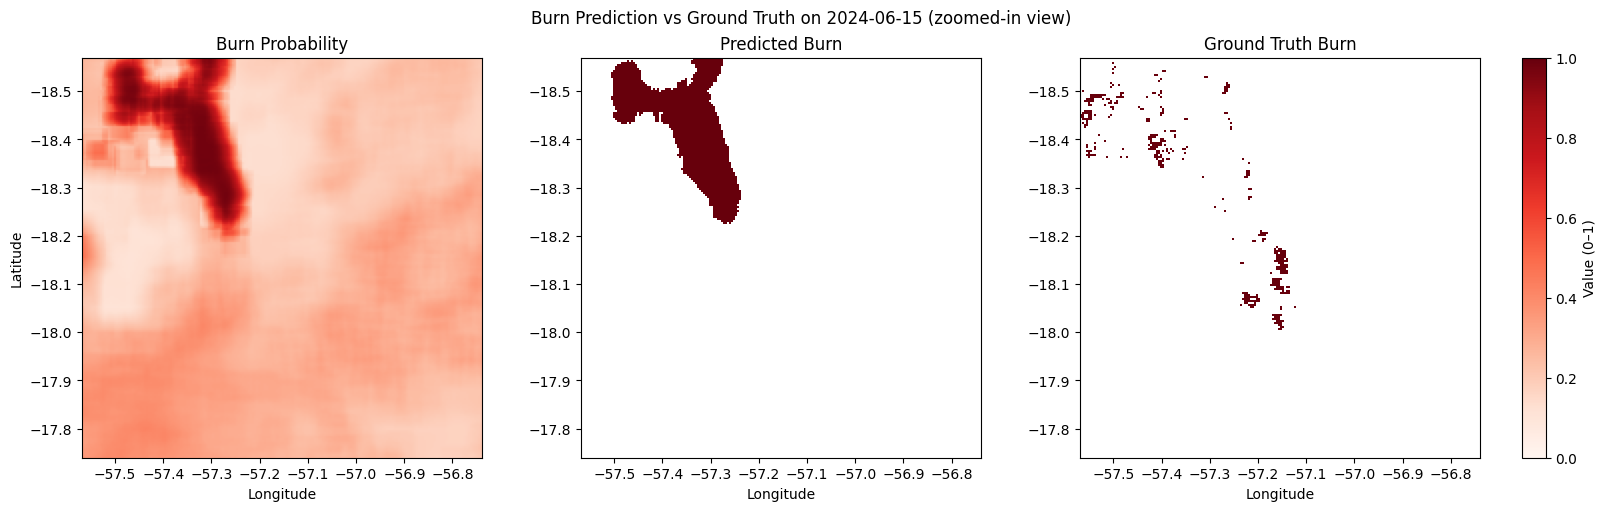

Accuracy: 0.9905869733013304
Precision: 0.008333002658624657
Recall: 0.2629931120851597
F1 Score: 0.0161541568107079


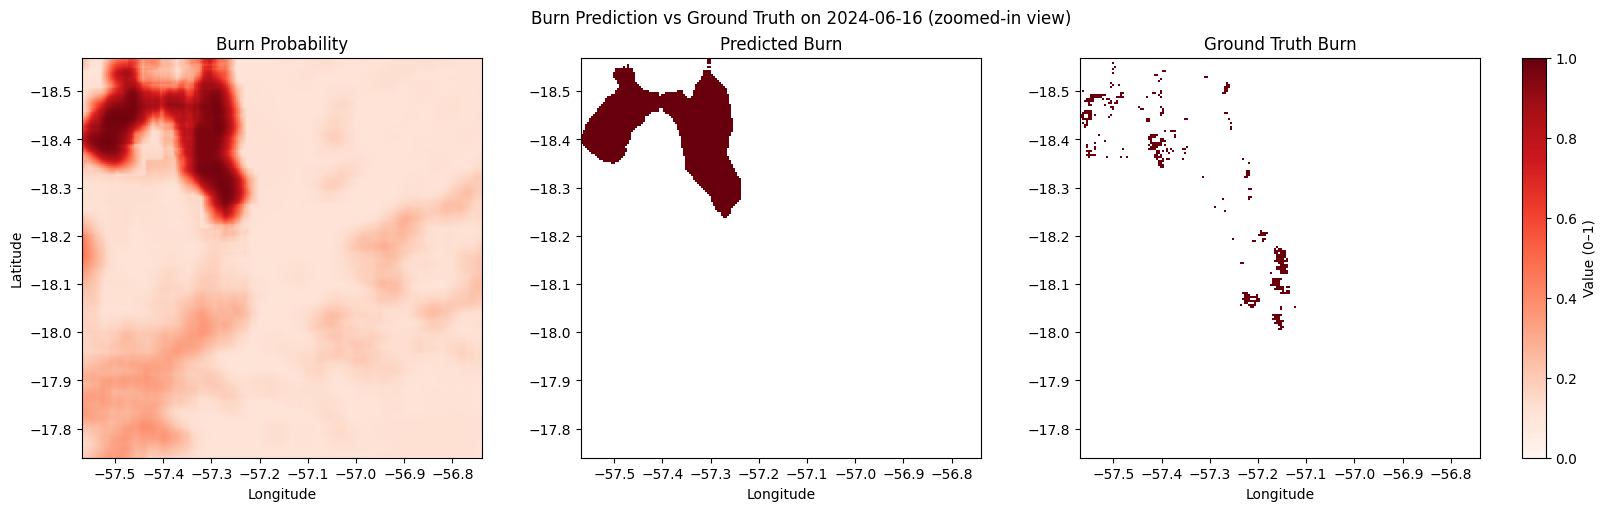

Accuracy: 0.9930457054066163
Precision: 0.011392165861296332
Recall: 0.26424546023794615
F1 Score: 0.02184265010351967


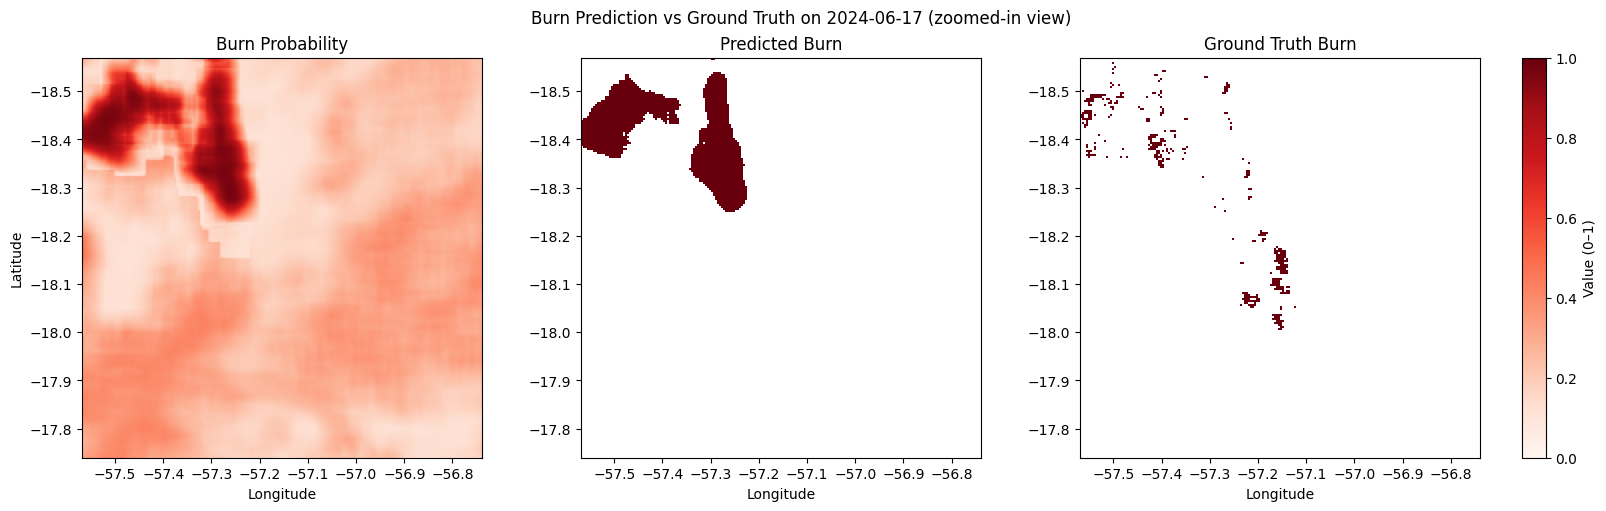

Accuracy: 0.993539733372095
Precision: 0.013641376908341557
Recall: 0.2943018159048215
F1 Score: 0.026074172699786412


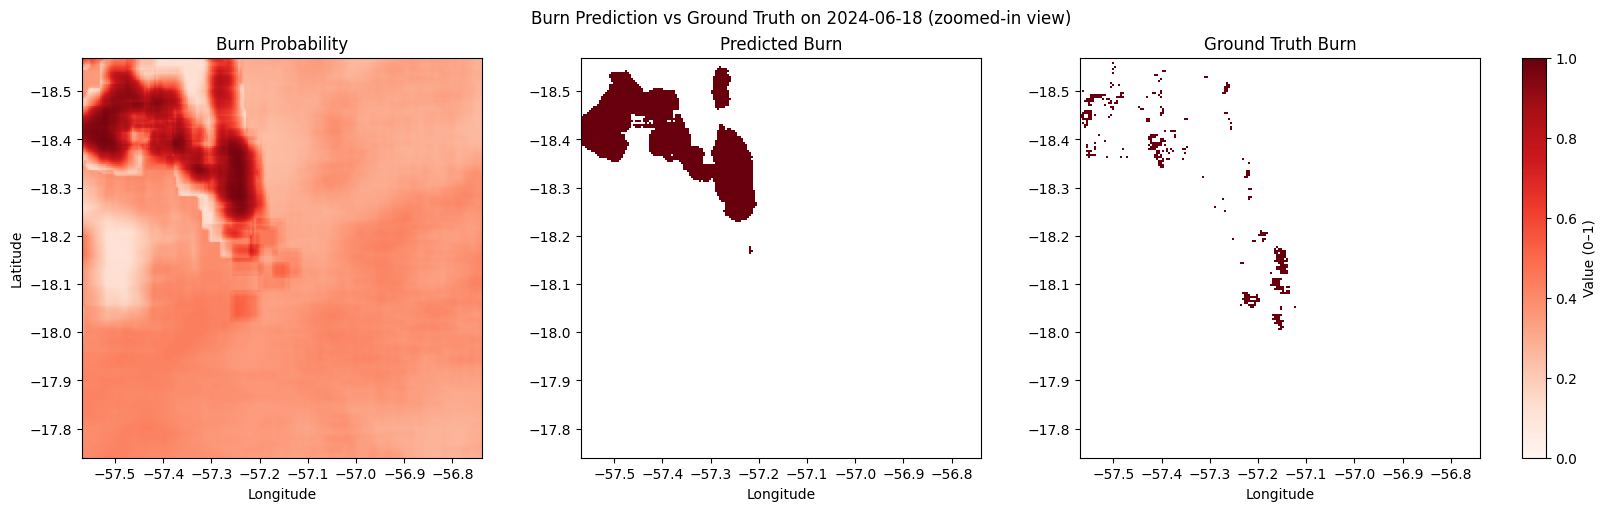

Accuracy: 0.9827515241728711
Precision: 0.005728691734162956
Recall: 0.3343769567939887
F1 Score: 0.011264396911783318


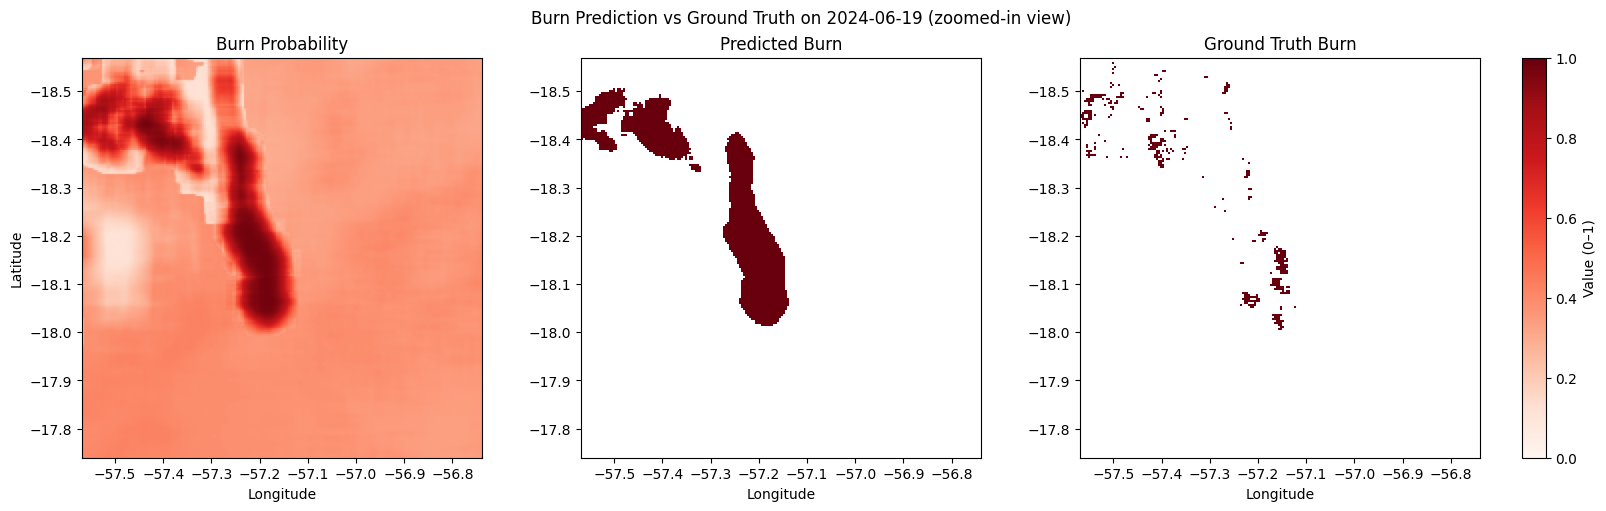

In [ ]:
csv_files = sorted(glob.glob("Testing_data/daily_csv/*.csv"))
columns = ['land_cover', 'dem', 't2m', 'd2m', 'u10', 'v10', 'tp', 'swvl1', 'sp', 'burn']
input_vars = columns
T = 5
prob_threshold = 0.975
all_five_probs = []

for i in range(0, 5)
  # --- Pick a sequence of 5 days to predict the last day ---
  stack = []
  dates = []

  for j in range(T):
      df = pd.read_csv(csv_files[i + j])
      date = csv_files[i + j].split("/")[-1].replace(".csv", "")
      dates.append(date)

      var_dict = {}
      for col in columns:
          arr = df[col].values.reshape(n_lat, n_lon)
          var_dict[col] = (["lat", "lon"], arr)

      ds_day = xr.Dataset(data_vars=var_dict, coords={"lat": lat_vals, "lon": lon_vals})
      stack.append(ds_day)

  ds_stack = xr.concat(stack, dim="time")
  ds_stack = ds_stack.assign_coords(time=pd.to_datetime(dates))

  input_vars = columns
  patch_size = 15

  infer_ds = InferencePatchDataset(ds_stack, input_vars, patch_size=patch_size)

  infer_loader = DataLoader(infer_ds, batch_size=64, shuffle=False)

  # model.eval()
  all_probs = np.zeros((ds_stack.sizes["lat"], ds_stack.sizes["lon"]))

  with torch.no_grad():
      for x, (i_idx, j_idx) in infer_loader:
          x = x.to(device)
          logits = model(x)
          probs = torch.sigmoid(logits).cpu().numpy().squeeze()

          for b in range(len(probs)):
              i, j = i_idx[b].item(), j_idx[b].item()
              all_probs[i, j] = probs[b]

  all_five_probs.append(all_probs)

  test_binary_image = (all_probs > prob_threshold).astype(int)
  burn_truth_image = ds_stack['burn'].isel(time=-1).values
  test_binary = np.reshape((all_probs > prob_threshold).astype(int), -1)
  burn_truth = np.reshape(ds_stack['burn'].isel(time=-1).values, -1)

  if np.sum(test_binary) > 5:

    print("Accuracy:", accuracy_score(burn_truth, test_binary))
    print("Precision:", precision_score(burn_truth, test_binary))
    print("Recall:", recall_score(burn_truth, test_binary))
    print("F1 Score:", f1_score(burn_truth, test_binary))

    mask = burn_truth_image > prob_threshold

    # Find connected components
    structure = np.ones((3, 3))  # 8-connectivity
    labeled_array, num_features = label(mask, structure=structure)

    # Count pixels in each component
    sizes = np.bincount(labeled_array.ravel())
    sizes[0] = 0  # background = 0

    # Find the label of the largest component
    largest_label = sizes.argmax()

    # Mask to keep only the largest cluster
    largest_cluster_mask = labeled_array == largest_label

    # Get bounding box of this cluster
    rows, cols = np.where(largest_cluster_mask)

    center_row = int(np.mean(rows))
    center_col = int(np.mean(cols))

    crop_size = 200
    half_crop = crop_size // 2

    # Ensure the window stays within bounds
    row_min = max(center_row - half_crop, 0)
    row_max = min(center_row + half_crop, all_probs.shape[0])
    col_min = max(center_col - half_crop, 0)
    col_max = min(center_col + half_crop, all_probs.shape[1])

    burn_prob_crop = all_probs[row_min:row_max, col_min:col_max]
    burn_pred_crop = test_binary_image[row_min:row_max, col_min:col_max].astype(float)
    burn_true_crop = burn_truth_image[row_min:row_max, col_min:col_max].astype(float)

    lat_crop = lat_vals[row_min:row_max] #lat_vals = np.sort(grid_df["lat"].unique())
                                    #lon_vals = np.sort(grid_df["lon"].unique())
    lon_crop = lon_vals[col_min:col_max]

    fig = plt.figure(figsize=(16, 5), constrained_layout=True)
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], figure=fig)

    # Create first axis normally
    axs0 = fig.add_subplot(gs[0])
    # Share y with axs0
    axs1 = fig.add_subplot(gs[1], sharey=axs0)
    axs2 = fig.add_subplot(gs[2], sharey=axs0)
    axs = [axs0, axs1, axs2]

    # Colorbar axis
    cax = fig.add_subplot(gs[3])

    vmin, vmax = 0.0, 1.0

    # Burn probability
    im0 = axs[0].imshow(burn_prob_crop, cmap='Reds', vmin=vmin, vmax=vmax,
                        extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]])
    axs[0].set_title("Burn Probability")
    axs[0].set_xlabel("Longitude")
    axs[0].set_ylabel("Latitude")

    reds = plt.colormaps['Reds'].copy()
    reds.set_bad(color='white')

    # Predicted burn
    burn_pred_crop[burn_pred_crop == 0] = np.nan
    im1 = axs[1].imshow(burn_pred_crop, cmap=reds, vmin=vmin, vmax=vmax,
                        extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
    axs[1].set_title("Predicted Burn")
    axs[1].set_xlabel("Longitude")

    # Ground truth
    burn_true_crop[burn_true_crop == 0] = np.nan
    im2 = axs[2].imshow(burn_true_crop, cmap=reds, vmin=vmin, vmax=vmax,
                        extent=[lon_crop[0], lon_crop[-1], lat_crop[-1], lat_crop[0]],interpolation='nearest')
    axs[2].set_title("Ground Truth Burn")
    axs[2].set_xlabel("Longitude")

    # Shared colorbar
    cbar = fig.colorbar(im2, cax=cax)
    cbar.set_label("Value (0–1)")

    fig.suptitle(f"Burn Prediction vs Ground Truth on 2024-06-{15+i} (zoomed-in view)")
    plt.show()